In [2]:
include("./DroneLibV2.jl")

plotMotorRpms (generic function with 1 method)

In [ ]:
function run_model_test(env::DroneEnv)
	action = [7850.0, 7850.0, 7850.0, 7850.0] |> gpu
	action = convert(CuArray{Float64, 1}, action)
	motors_rpm = []
	state_spaces = []
	reset!(env)
	episode_reward = 0.0
	num_steps = 0
	while true
		state = get_state(env.drone)
		if num_steps == 2500
			action = [7850.0, 7850.0, 7860.0, 7860.0] |> gpu
			action = convert(CuArray{Float64, 1}, action)
		elseif num_steps == 2520
			action = [7860.0, 7860.0, 7850.0, 7850.0] |> gpu
			action = convert(CuArray{Float64, 1}, action)
		elseif num_steps == 2540
			action = [0.0, 0.0, 0.0, 0.0] |> gpu
			action = convert(CuArray{Float64, 1}, action)
		end
		reward, done = step!(env, action, true)
		episode_reward += reward
		push!(motors_rpm, convert(Array{Float64, 1}, action))
		push!(state_spaces, convert(Array{Float64, 1}, state))
		num_steps += 1
		if done
			break
		end
	end
	return state_spaces, motors_rpm
end

In [5]:
function pid_control_3d(env::DroneEnv, max_rpm::Float64, kp::Array{Float64, 1}, ki::Array{Float64, 1}, kd::Array{Float64, 1})
    current_pos = env.drone.position
    target_pos = env.target_position
    # Errors and integral variables for each axis (initialize to zero)


    errors = zeros(6)
    integrals = zeros(6)
    derivatives = zeros(6)
    prev_errors = zeros(6)

    state_spaces = []
    motor_rpms = []

	### Set the rpm for reaching height first
	while true
        current_pos = env.drone.position
        current_orientation = env.drone.angular_velocity

        errors = [ target_pos[1] - current_pos[1], target_pos[2] - current_pos[2], target_pos[3] - current_pos[3], 0 - current_orientation[1], 0 - current_orientation[2], 0 - current_orientation[3]]
        
        integrals += errors / frequency
        derivatives = (errors - prev_errors) * frequency

        ### First we need to control the height of the drone
		rpm_motors = (ones(4)) * (kp[2] * errors[3] + ki[2] * integrals[3] + kd[2] * derivatives[3])

        ### Now we need to control the x and y position of the drone
        if current_pos[3] > 5e-2
            change_in_x = kp[1] * errors[1] + ki[1] * integrals[1] + kd[1] * derivatives[1]
            change_in_y = kp[1] * errors[2] + ki[1] * integrals[2] + kd[2] * derivatives[2]

            rpm_motors[1] -= (change_in_x + change_in_y)
            rpm_motors[2] -= (change_in_x - change_in_y)
            rpm_motors[3] += (change_in_x + change_in_y)
            rpm_motors[4] += (change_in_x - change_in_y)
        end

        ### Now we need to control the yaw, pitch and roll of the drone
        change_in_roll = kp[1] * errors[4] + ki[1] * integrals[4] + kd[1] * derivatives[4]
        change_in_pitch = kp[1] * errors[5] + ki[1] * integrals[5] + kd[1] * derivatives[5]
        change_in_yaw = kp[1] * errors[6] + ki[1] * integrals[6] + kd[1] * derivatives[6]

        # change_in_roll = kp[3] * errors[4] + ki[3] * integrals[4] + kd[3] * derivatives[4]
        # change_in_pitch = kp[3] * errors[5] + ki[3] * integrals[5] + kd[3] * derivatives[5]
        # change_in_yaw = kp[3] * errors[6] + ki[3] * integrals[6] + kd[3] * derivatives[6]
        
        rpm_motors[1] += (change_in_yaw + change_in_pitch + change_in_roll)
        rpm_motors[2] += (change_in_yaw - change_in_pitch - change_in_roll)
        rpm_motors[3] += (change_in_yaw - change_in_pitch + change_in_roll)
        rpm_motors[4] += (change_in_yaw + change_in_pitch - change_in_roll)

        rpm_motors = min.(rpm_motors, 14000)
        rpm_motors = max.(rpm_motors, 0)
        reward, done = step!(env, rpm_motors)

        if done || norm(target_pos - current_pos) < 1e-4
            println("RPM of motors: ", rpm_motors)
			break
		end

        prev_errors[1:6] = errors[1:6]

        push!(state_spaces, get_state(env.drone))
        push!(motor_rpms, rpm_motors)

    end
    return state_spaces, motor_rpms
end

pid_control_3d (generic function with 1 method)

Initial position: [0.0, 0.0, 0.0]
angular velocity too large
RPM of motors: [8006.587559072541, 7252.237010282011, 7252.237010282011, 8006.587559072541]
Final position: [1.6375965763285416e-14, 0.012216219407171018, 2.723523379093865]


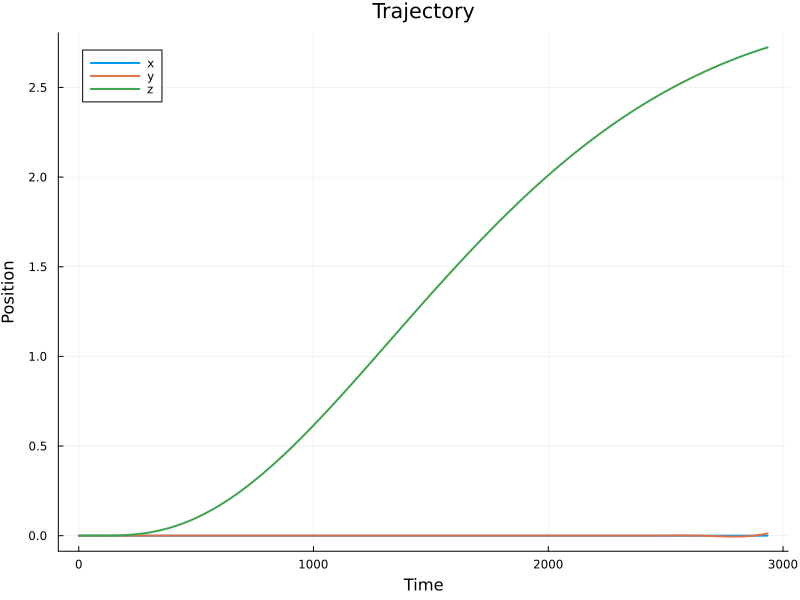

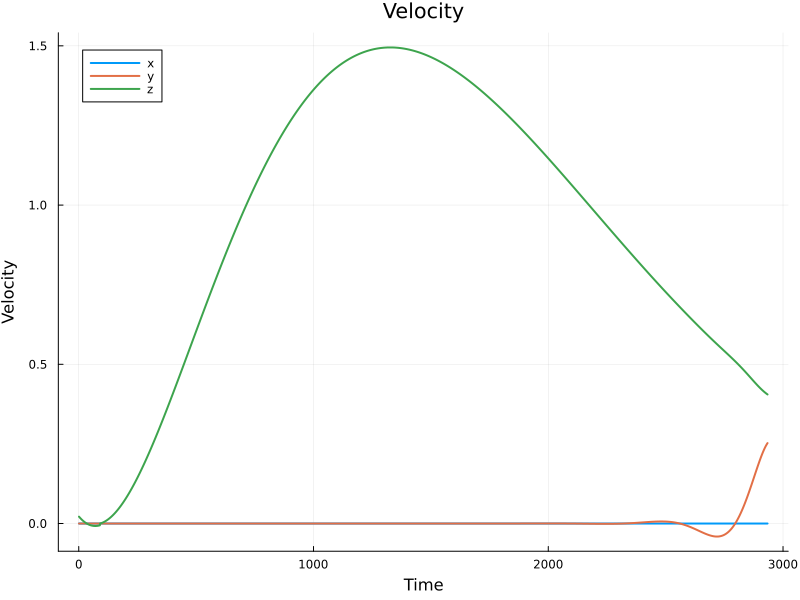

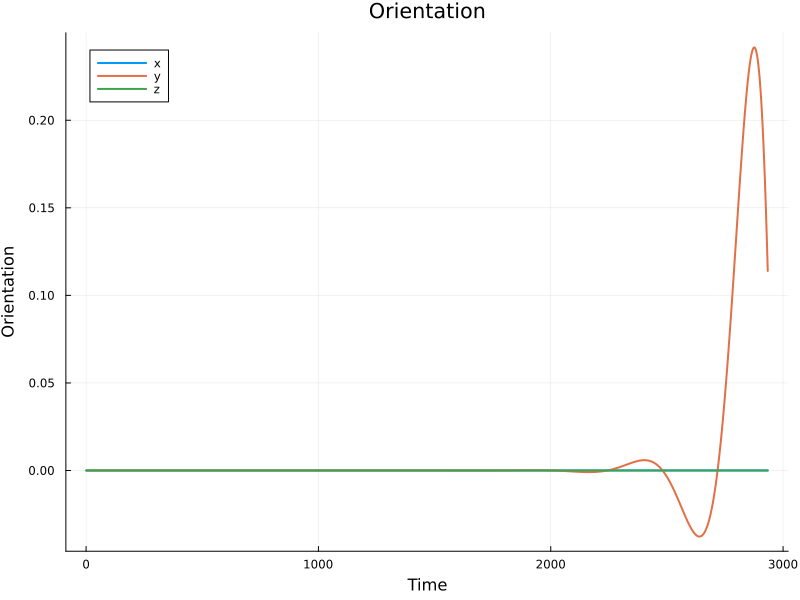

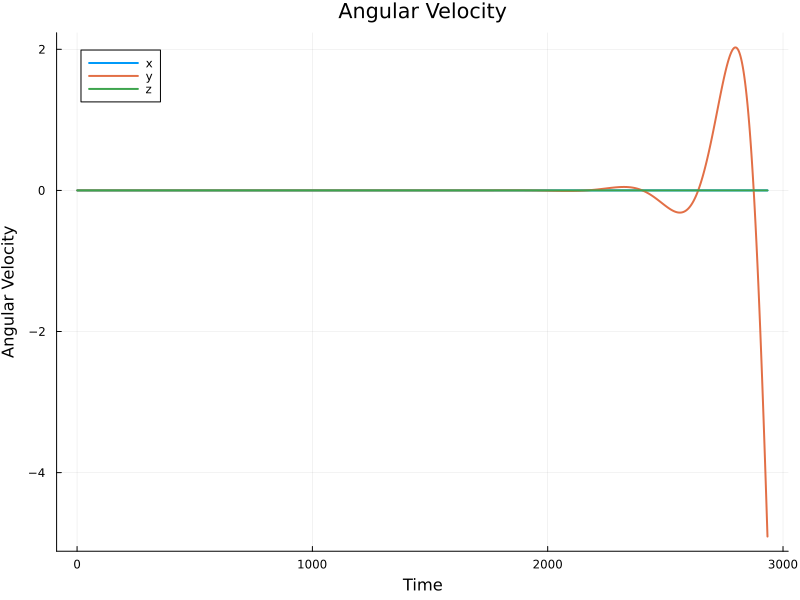

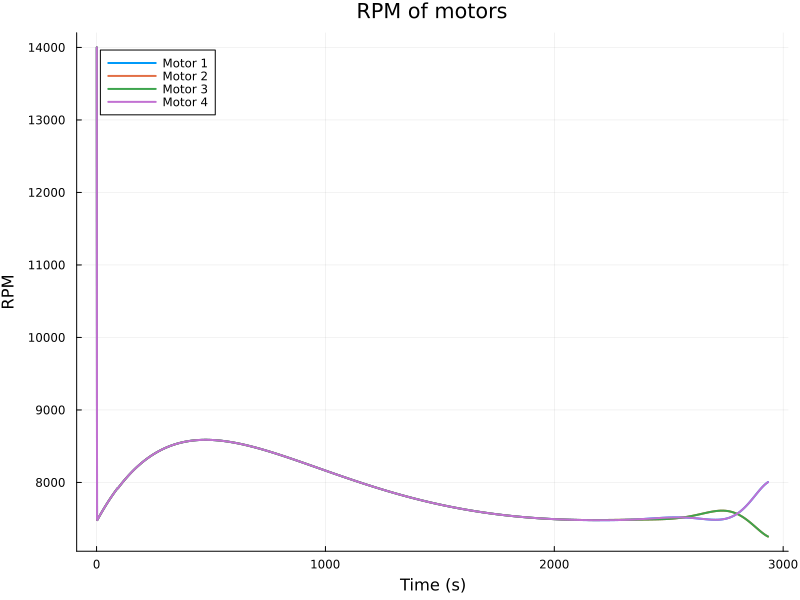

In [63]:
env = DroneEnv([0.0, 1.0, 3.0], 10.0)
println("Initial position: ", env.drone.position)
kp = [2e-7, 2500.0, 10]
ki = [1e-6, 1500.0, 0]
kd = [1e-10, 1500.0, 0]
max_rpm = 14000.0

state_spaces = []

num_steps = 0

state_spaces, motor_rpms = pid_control_3d(env, max_rpm, kp, ki, kd)

println("Final position: ", env.drone.position)

plotStateSpaces(state_spaces)
plotMotorRpms(motor_rpms)

In [2]:
struct Actor
    model::Chain
end

function Actor(state_dim::Int, action_dim::Int, max_action::Float64)
    ### Define the parameters of each layer of type Float64
    model = Chain(
        # Dense(state_dim, 256, relu; init=Flux.glorot_uniform(gain=2)),
        # Dense(256, 512, relu; init=Flux.glorot_uniform(gain=2)),
        # Dense(512, 1024, relu; init=Flux.glorot_uniform(gain=2)),
        # Dense(1024, 1024, relu; init=Flux.glorot_uniform(gain=2)),
        # Dense(1024, 256, relu; init=Flux.glorot_uniform(gain=2)),
        # Dense(256, 64, relu; init=Flux.glorot_uniform(gain=2)),
        # Dense(64, action_dim, sigmoid; init=Flux.glorot_uniform(gain=2))
        Dense(state_dim, 256, relu),
        Dense(256, 512, relu),
        Dense(512, 1024, relu),
        Dense(1024, 1024, relu),
        Dense(1024, 256, relu),
        Dense(256, 64, relu),
        Dense(64, action_dim, tanh)
    ) |> gpu
    return Actor(model)
end

Actor

In [12]:
actor = Actor(19, 4, 14000.0)

Actor(Chain(Dense(19 => 256, relu), Dense(256 => 512, relu), Dense(512 => 1024, relu), Dense(1024 => 1024, relu), Dense(1024 => 256, relu), Dense(256 => 64, relu), Dense(64 => 4, tanh)))

In [13]:
actor_model = actor.model

Chain(
  Dense(19 => 256, relu),               # 5_120 parameters
  Dense(256 => 512, relu),              # 131_584 parameters
  Dense(512 => 1024, relu),             # 525_312 parameters
  Dense(1024 => 1024, relu),            # 1_049_600 parameters
  Dense(1024 => 256, relu),             # 262_400 parameters
  Dense(256 => 64, relu),               # 16_448 parameters
  Dense(64 => 4, tanh),                 # 260 parameters
)                   # Total: 14 arrays, 1_990_724 parameters, 1.930 KiB.

In [19]:
state = zeros(19) |> gpu

state[17:19] = [1.0, 1.0, 1.0]

action = actor_model(state)

4-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
 -0.9877317
 -0.9011176
  0.8927277
  0.99973327

In [1]:
using BSON: @load

In [17]:
@load "agent_actor_model.bson" actor_model

actor_model = actor_model |> gpu

Chain(
  Dense(19 => 256, relu),               # 5_120 parameters
  Dense(256 => 512, relu),              # 131_584 parameters
  Dense(512 => 1024, relu),             # 525_312 parameters
  Dense(1024 => 1024, relu),            # 1_049_600 parameters
  Dense(1024 => 256, relu),             # 262_400 parameters
  Dense(256 => 64, relu),               # 16_448 parameters
  Dense(64 => 4, tanh),                 # 260 parameters
)                   # Total: 14 arrays, 1_990_724 parameters, 1.930 KiB.

In [12]:
randn!(zeros(10, 10))

10×10 Matrix{Float64}:
 -1.10192     0.945704   0.261278   …  -3.05202      0.825297   0.409417
  0.641019    0.307541   0.107625      -0.0273586   -0.553353  -0.550411
 -0.353264   -0.29625    0.652063       0.250524    -1.39331   -1.56508
 -0.859916    1.61709   -0.824944       0.278985    -0.791438   0.84578
 -0.443242    0.669117   0.298931       2.30747      0.358344  -1.99392
  0.572542    0.652133  -2.00121    …   0.0714464    0.928864  -0.392469
 -1.78652     1.31215    0.0316676      1.47004      0.474408   0.0780345
  1.33256    -0.601757  -0.280365      -0.651647     0.313005   0.459266
  0.594595    0.982782  -0.562338      -0.00589568  -0.680197   0.551269
 -0.0846259   1.28755    1.10329       -0.187817    -0.290961  -0.497783